In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
from tqdm import tqdm
import matplotlib
import h5py

import calculation.MeanFieldv2 as MFv2
import calculation.CurrentMeirv2 as CMv2
import calculation.SusceptibilitySimpv2 as Susceptv2

In [2]:
### Parameters

couplingValue = 0.7

lambdaSamples = np.array([1.0])
voltageNewSpace = np.linspace(1e-5, 1.0, 60)
TNewSpace = np.linspace(1e-5, 0.45, 60)


# voltageNewSpace = np.linspace(0.5, 1.0, 20)
# TNewSpace = np.linspace(1e-5, 0.25, 20)

## Initial Conditions
phiConstantInit = 0.5
phiLambdaInit = 0.9

In [3]:
def computeSaddlePoints(lambdaSamples, Tvalue, voltageSpacePlot, pbar=None):
    
    saddle_points = np.zeros(len(voltageSpacePlot), dtype=float)
    lambdaValue = lambdaSamples[0]
    for i in range(len(voltageSpacePlot)):
        voltageValue = voltageSpacePlot[i]
        result = scipy.optimize.root(MFv2.computeMFLambda, phiConstantInit, args=(lambdaValue, voltageValue, Tvalue, MFv2.Impy, couplingValue), method='lm', tol=1e-6)
        saddle_points[i] = result.x[0]
            
        if pbar is not None:
            pbar.update(1)
    
    return saddle_points


phi_voltage_T = np.zeros((len(TNewSpace), len(voltageNewSpace)), dtype=float)
pbar = tqdm(total=len(TNewSpace)*len(voltageNewSpace), desc='Computing phi(T)')

for i in range(len(TNewSpace)):
    Tvalue = TNewSpace[i]
    phi_voltage_T[i,:] = computeSaddlePoints(lambdaSamples, Tvalue, voltageNewSpace, pbar=pbar)
pbar.close()



Computing phi(T):   0%|          | 0/3600 [00:00<?, ?it/s]

Computing phi(T): 100%|██████████| 3600/3600 [01:11<00:00, 50.66it/s]


(60, 60)


Text(0, 0.5, 'phi')

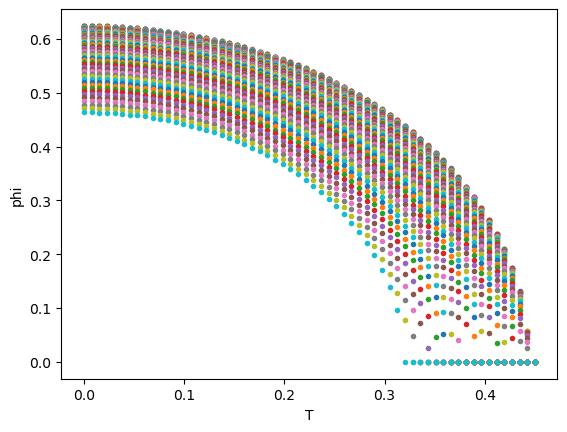

In [4]:
print(phi_voltage_T.shape)

for i in range(phi_voltage_T.shape[1]):
    plt.plot(TNewSpace, phi_voltage_T[:,i], '.')

plt.xlabel("T")
plt.ylabel("phi")

In [5]:

hstep = 1e-5
omegaSpace = np.linspace(-hstep, hstep, 2)

PiR = np.zeros((len(TNewSpace), len(voltageNewSpace), len(omegaSpace)), dtype=np.complex128)
PiK = np.zeros((len(TNewSpace), len(voltageNewSpace),len(omegaSpace)), dtype=np.complex128)

lambdaValue = lambdaSamples[0]
pbar = tqdm(total=len(TNewSpace)*len(voltageNewSpace), desc='Computing PiR and PiK')

for i in range(len(TNewSpace)):
   Tvalue = TNewSpace[i]
   for j in range(len(voltageNewSpace)):
      voltageValue = voltageNewSpace[j]
      phiValue = phi_voltage_T[i, j]
      
      PiR[i, j,:] = Susceptv2.computePiR(omegaSpace, lambdaValue, phiValue, voltageValue, couplingValue, Tvalue=Tvalue)
      PiK[i, j,:] = Susceptv2.computePiKnum(omegaSpace, lambdaValue, phiValue, voltageValue, couplingValue, Tvalue=Tvalue)
         
      pbar.update(1)

pbar.close()


Computing PiR and PiK: 100%|██████████| 3600/3600 [03:59<00:00, 15.05it/s]


In [6]:

chiR = PiR/(2.0*lambdaValue**2)
chiK = PiK/(2.0*lambdaValue**2)

FauxPlus = chiR[:,:,1].imag/chiK[:,:,1].imag
FauxMinus = chiR[:,:,0].imag/chiK[:,:,0].imag

dFaux = (FauxPlus - FauxMinus)/(2*hstep)


(3600,)
(3600,)


(-0.01, 0.3)

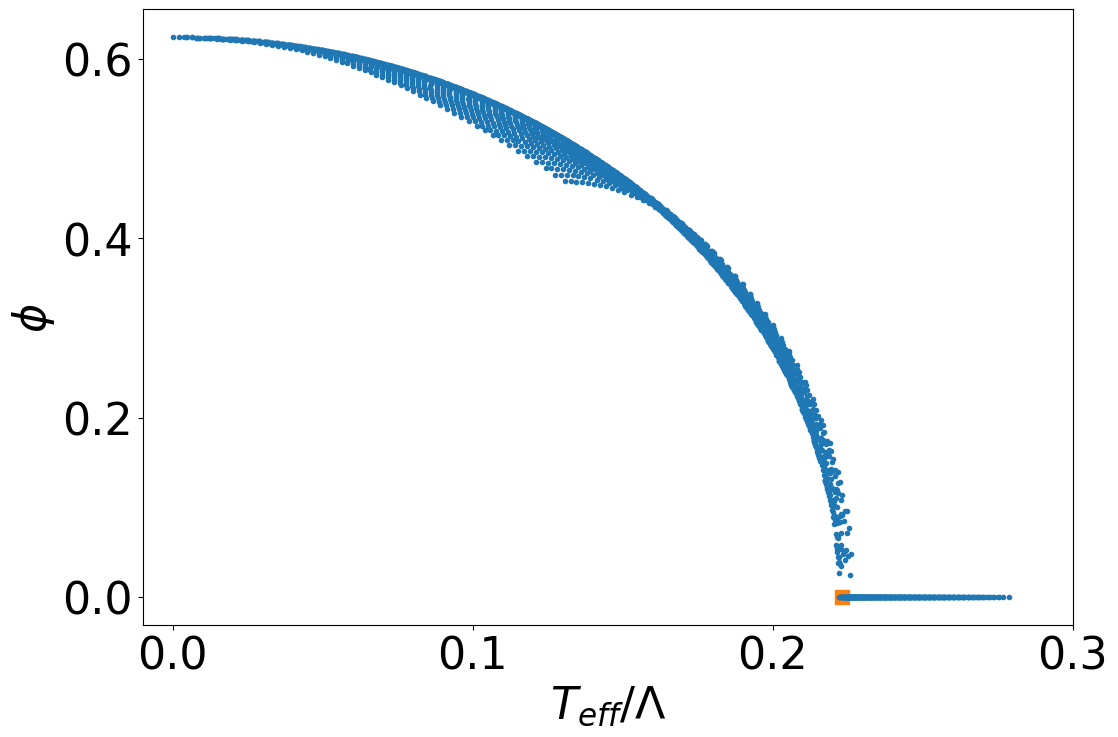

In [7]:


dFaux_reshaped = dFaux.reshape(-1)
phi_reshaped = phi_voltage_T.reshape(-1)

print(dFaux_reshaped.shape)
print(phi_reshaped.shape)


fig, ax = plt.subplots(figsize=(12, 8))
plt.rcParams['text.usetex'] = True
plt.rcParams['font.family'] = 'serif'
ax.plot(0.5/dFaux_reshaped/2, phi_reshaped, '.')

ax.tick_params(axis='y', labelsize=32)
ax.tick_params(axis='x', labelsize=32)

plt.ylabel(r'$\phi$', fontsize=32)
plt.xlabel(r'$T_{eff}/\Lambda$', fontsize=32)

x0 = 0.223
ax.scatter(x=x0, y=0, s=100, marker="s", color='C1', label=f'Point @ x={0.223:.1f}')

# # 2) Grab existing xticks, append x0, sort, and re-set them
# ticks = list(ax.get_xticks())
# ticks.append(x0)
# ticks = sorted(set(ticks))
# ax.set_xticks(ticks)

# # 3) Build matching labels: use 'T_c' at x0, and default formatting elsewhere
# labels = []
# for t in ticks:
#     if np.isclose(t, x0):
#         labels.append(r'$T_{c,0}$')      # LaTeX-style Tc
#     else:
#         labels.append(f'{t:g}')      # or use your preferred formatting
# ax.set_xticklabels(labels)

# # optional: tighten up the bottom margin so the new label isn’t clipped
# plt.subplots_adjust(bottom=0.15)

plt.xlim(-0.01, 0.3)

# plt.savefig("panels/phi_Teff.png")

(3600,)
(3600,)


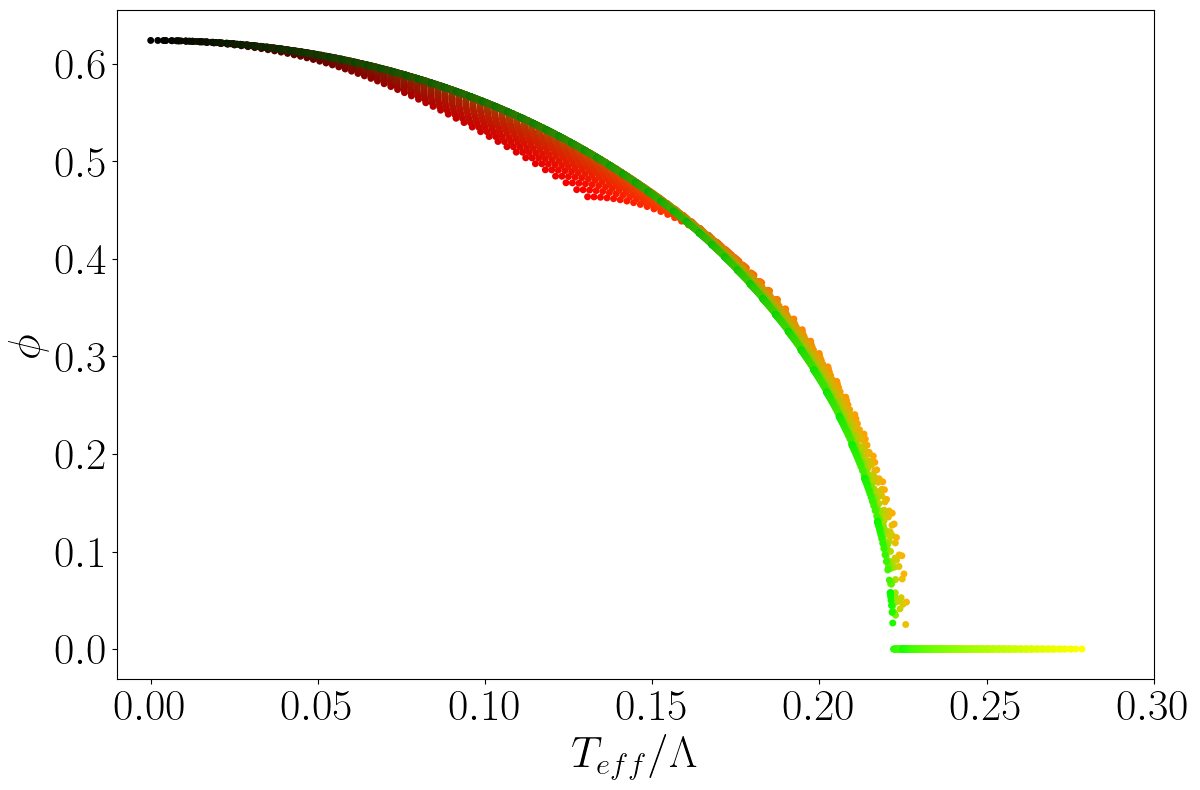

In [8]:

dFaux_reshaped = dFaux.reshape(-1)
phi_reshaped = phi_voltage_T.reshape(-1)

print(dFaux_reshaped.shape)
print(phi_reshaped.shape)


n_points_x = 60
n_points_y = 60

x_min, x_max = 1e-5, 1.6/2
y_min, y_max = 1e-5, 0.65/2


# n_points_x = 20
# n_points_y = 20

# x_min, x_max = 1e-5, 1.6/2
# y_min, y_max = 1e-5, 0.65/2


x = np.linspace(x_min, x_max, n_points_x)
y = np.linspace(y_min, y_max, n_points_y)
X, Y = np.meshgrid(x, y)

X_flat = X.flatten()
Y_flat = Y.flatten()

R = (X_flat - x_min) / (x_max - x_min)
G = (Y_flat - y_min) / (y_max - y_min)
B = np.zeros_like(R)

colors = np.stack((R, G, B), axis=1)

# colors = colors.reshape(-1, 3)

fig, ax = plt.subplots(figsize=(12, 8))
plt.rcParams['text.usetex'] = True
plt.rcParams['font.family'] = 'serif'

# Use ax.scatter to set color per-point
sc = ax.scatter(
    0.5 / dFaux_reshaped / 2,  # x data
    phi_reshaped,              # y data
    c=colors,                  # color per-point
    s=100,                     # marker size (optional)
    marker='.',                # point marker (optional)
    edgecolor='none'           # no border
)

x_space = np.linspace(0.15, 0.29, 2000)
# plt.plot(x_space, 1.9*np.sqrt(0.223-x_space), linewidth=4.0)

ax.tick_params(axis='y', labelsize=32)
ax.tick_params(axis='x', labelsize=32)

plt.ylabel(r'$\phi$', fontsize=32)
plt.xlabel(r'$T_{eff}/\Lambda$', fontsize=32)

x0 = 0.223
# ax.scatter(x=x0, y=0, s=100, marker="s", color='blue')

plt.xlim(-0.01, 0.3)

plt.tight_layout()
# plt.savefig("panels/phi_Teff_2.png")

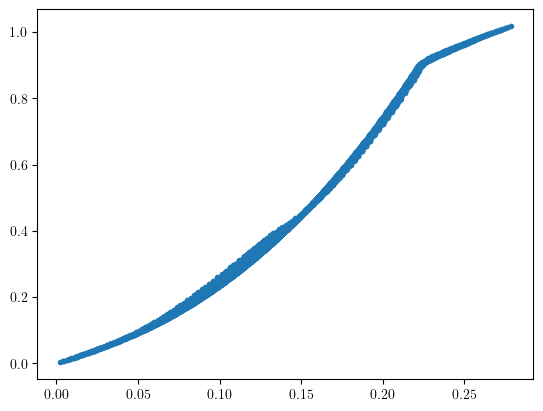

In [25]:

Teff = 0.5 / dFaux_reshaped / 2
Fplus =  (chiK[:,:,1].imag).reshape(-1)
# Fminus = FauxMinus.reshape(-1)

plt.plot(Teff[1:], Fplus[1:], '.')
# plt.yscale('log')
# plt.plot(Teff[1:], Fminus[1:], '.')

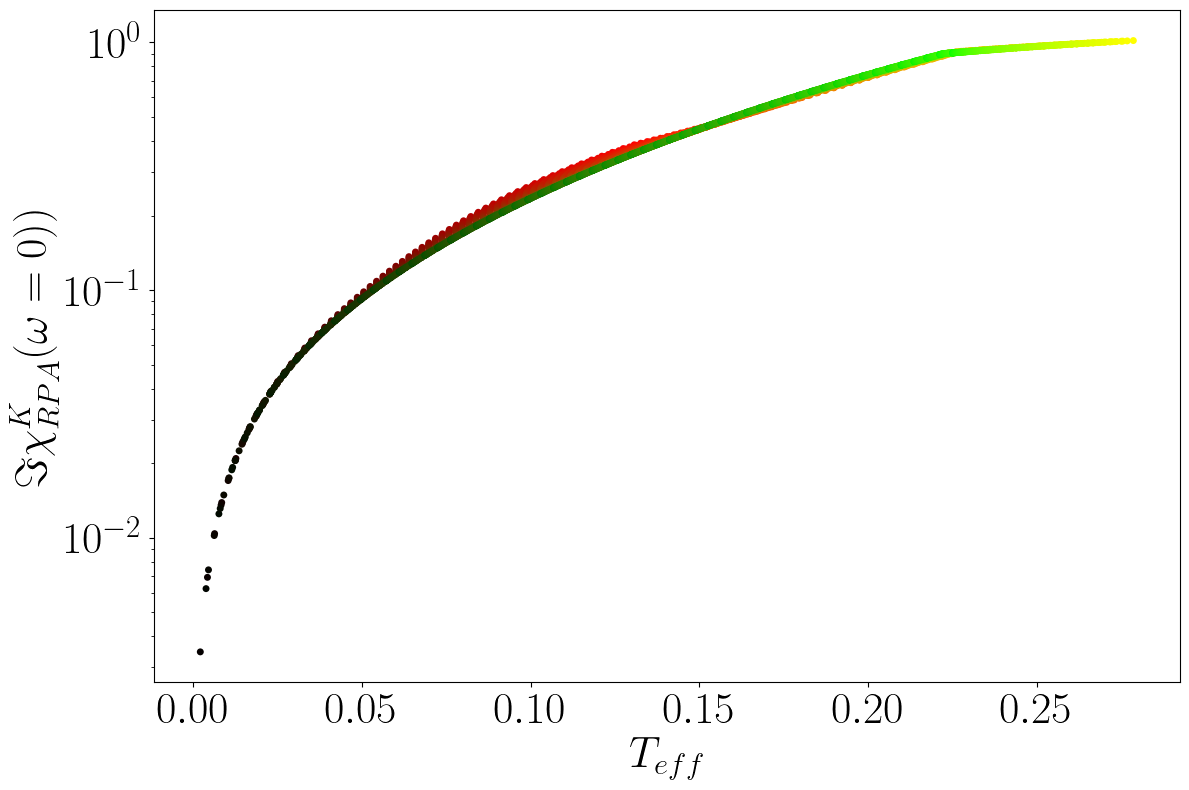

In [30]:
fig, ax = plt.subplots(figsize=(12, 8))
plt.rcParams['text.usetex'] = True
plt.rcParams['font.family'] = 'serif'

Teff = 0.5 / dFaux_reshaped / 2
Fplus =  (chiK[:,:,1].imag).reshape(-1)

# Use ax.scatter to set color per-point
sc = ax.scatter(
    Teff[1:],  # x data
    Fplus[1:],              # y data
    c=colors[1:],                  # color per-point
    s=100,                     # marker size (optional)
    marker='.',                # point marker (optional)
    edgecolor='none'           # no border
)

x_space = np.linspace(0.15, 0.29, 2000)
# plt.plot(x_space, 1.9*np.sqrt(0.223-x_space), linewidth=4.0)

plt.yscale('log')
ax.tick_params(axis='y', labelsize=32)
ax.tick_params(axis='x', labelsize=32)

plt.ylabel(r'$\Im \chi^K_{RPA}(\omega=0))$', fontsize=32)
plt.xlabel(r'$T_{eff}$', fontsize=32)

plt.tight_layout()
# plt.grid()
plt.savefig('panelsCurrentNoise/ImChiK_RPA_Teff.png', bbox_inches='tight', dpi=600)